# LAB 3 : interpretability and explainability in NLP models using Allennlp

In today’s world, public content has never been more relevant. Data from customer reviews is being used as a tool to gain insight into consumption-related decisions as the understanding of its associated sentiment grants businesses invaluable market awareness and the ability to proactively address issues early.

Sentiment analysis uses a process to computationally determine whether a piece of writing is positive, negative, neutral, or mixed.

(if you want a fully managed service to do so, use amazon Comprehend ! https://aws.amazon.com/blogs/machine-learning/detect-sentiment-from-customer-reviews-using-amazon-comprehend/)

- http://www.realworldnlpbook.com/blog/training-sentiment-analyzer-using-allennlp.html
- https://github.com/mhagiwara/realworldnlp/blob/master/examples/sentiment/sst_classifier.py
- https://allennlp.org/tutorials

This workshop uses the publicly available dataset Stanford Sentiment TreeBank for sentiment classification (https://nlp.stanford.edu/sentiment/index.html), which is one of the most widely used sentiment datasets nowadays (in SSt, sentiment lables are assigned not only to sentences but also to every phrase, and every word in sentences). 




## Pytorch and Allen NLP

- Pytorch : An open source machine learning framework that accelerates the path from research prototyping to production deployment (https://pytorch.org/)
- AllenNLP: An open-source NLP research library, built on PyTorch (https://allennlp.org/)

## Model and implementation
in this workshop, we gonna create a model that classifies a sentence into classes. To do so, we use a standard LSTM-RNN plus a fully connected linear layer for classification.

## prerequesites

- please download and add to your instance the SST data following the link https://nlp.stanford.edu/sentiment/ or doing the link from http://www.realworldnlpbook.com/blog/training-sentiment-analyzer-using-allennlp.html
- please git clone https://github.com/mhagiwara/realworldnlp 
- https://github.com/allenai/allennlp

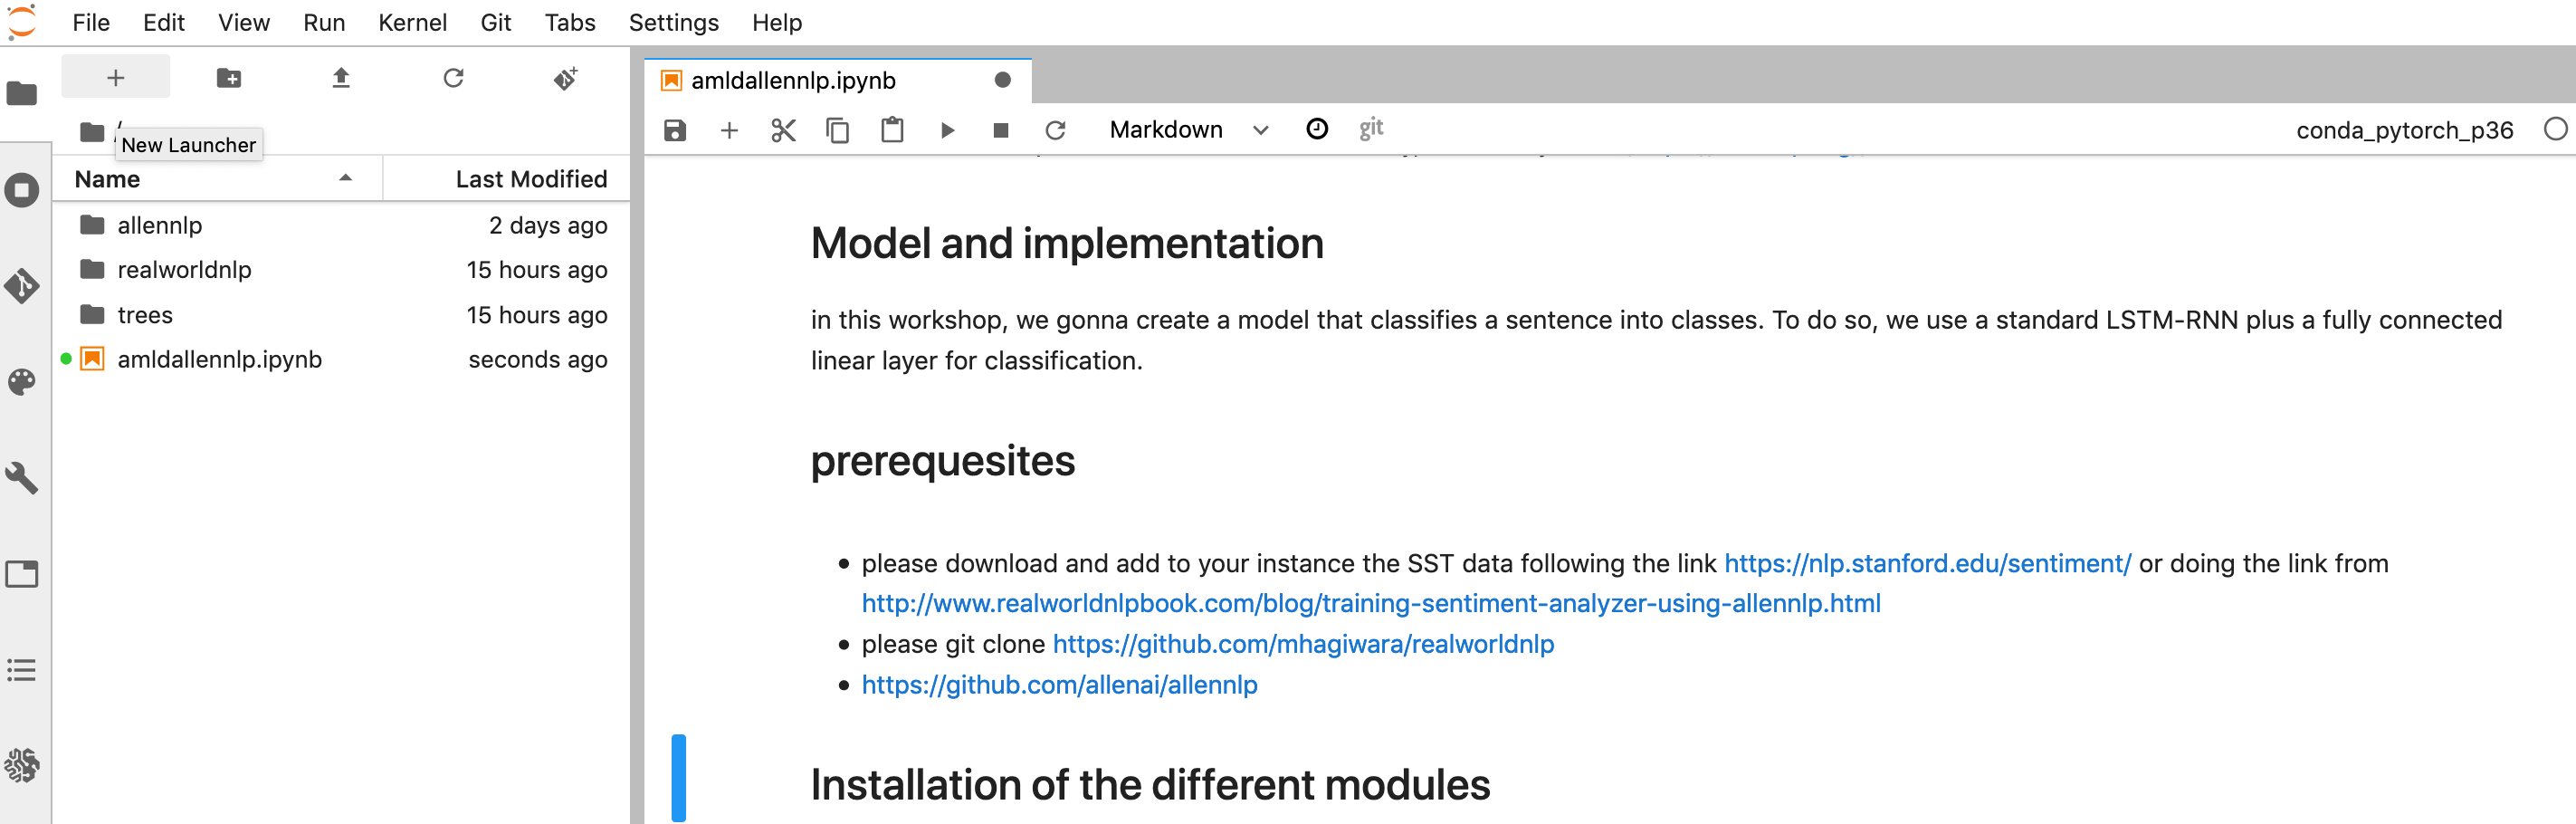

## Installation of the different modules

In [1]:
!pip install nvidia-ml-py3

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install --ignore-installed greenlet

  Using cached https://files.pythonhosted.org/packages/bf/45/142141aa47e01a5779f0fa5a53b81f8379ce8f2b1cd13df7d2f1d751ae42/greenlet-0.4.15-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install allennlp

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## let's start now! 

In [4]:
import allennlp

In AllenNLP, use of type annotations for just about everything.

In [5]:
from typing import Dict

AllenNLP is built on top of PyTorch, so it uses its code freely

In [6]:
import numpy as np
import torch
import torch.optim as optim

AllenNLP already provides a handy dataset reader called **StanfordSentimentTreeBankDatasetReader** --- an interface for reading the SST dataset. You can read the dataset by specifying the path to the dataset files as the argument for the read() method

In [7]:
from allennlp.data.dataset_readers.stanford_sentiment_tree_bank import \
    StanfordSentimentTreeBankDatasetReader

In the training it'll need a **DataIterators** that can intelligently batch data.

In [8]:
from allennlp.data.iterators import BucketIterator

Whereas a TokenIndexer represents a rule for how to turn a token into indices, a Vocabulary contains the corresponding mappings from strings to integers. For example, your token indexer might specify to represent a token as a sequence of character ids, in which case the Vocabulary would contain the mapping {character -> id}. In this particular example we use a SingleIdTokenIndexer that assigns each token a unique id, and so the Vocabulary will just contain a mapping {token -> id} (as well as the reverse mapping).

In [9]:
from allennlp.data.vocabulary import Vocabulary

Besides **DatasetReader**, the other class you'll typically need to implement is **Model**, which is a PyTorch Module that takes tensor inputs and produces a dict of tensor outputs (including the training loss you want to optimize).

In [10]:
from allennlp.models import Model


As mentioned above, our model will consist of **an embedding layer, followed by a LSTM, then by a feedforward layer**. AllenNLP includes abstractions for all of these that smartly handle padding and batching, as well as various utility functions.

In [11]:
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.nn.util import get_text_field_mask

To track accuracy on the training and validation datasets and use of AllenNLP's full-featured **Trainer**.

In [12]:
from allennlp.training.metrics import CategoricalAccuracy, F1Measure
from allennlp.training.trainer import Trainer

In [13]:
from realworldnlp.predictors import SentenceClassifierPredictor

Size for the embedding layer and for the hidden layer of the LSTM

In [14]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128

let's definte the model that classifies a sentence into classes. The model is a **standard LSTM-RNN plus a fully connected linear layer for classification**. 

The key in the following code is to **Seq2VecEncoder**, which basically takes a sequence of tensors, and returns a single vector. We use an LSTM-RNN implementation as the encoder (Take a look at the documentation for PytorchSeq2VecWrapper for why we need it). please check the structure of the LstmClassifier model we write. The **Model** is a subclass of torch.nn.Module. How it works is largely up to you, it mostly just needs a forward method that takes tensor inputs and produces a dict of tensor outputs that includes the loss you'll use to train the model. As mentioned above, our model will consist of an embedding layer, a seq2vec encoder, and a feedforward network.
- in the def__init__ step : we pass in the embedder and the seq2vec encoder as constructor parameters. This allows to experiment with different embedders and encoders without having to change the model code. The embedding layer is specified as an AllenNLP **TextFieldEmbedder** which represents a general way of turning tokens into tensors
- we then implement forward, which is where the actual computation happens. Each Instance in your dataset will get (batched with other instances and) fed into forward
- we then include an accuracy metric that gets updated each forward pass. That means we need to override a get_metrics method that pulls the data out of it

In [15]:
# Model in AllenNLP represents a model that is trained.
@Model.register("lstm_classifier")
class LstmClassifier(Model):
    def __init__(self,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2VecEncoder,
                 vocab: Vocabulary,
                 positive_label: str = '4') -> None:
        super().__init__(vocab)
        # We need the embeddings to convert word IDs to their vector representations
        self.embedder = embedder

        self.encoder = encoder

        # After converting a sequence of vectors to a single vector, we feed it into
        # a fully-connected linear layer to reduce the dimension to the total number of labels.
        self.linear = torch.nn.Linear(in_features=encoder.get_output_dim(),
                                      out_features=vocab.get_vocab_size('labels'))

        # Monitor the metrics - we use accuracy, as well as prec, rec, f1 for 4 (very positive)
        positive_index = vocab.get_token_index(positive_label, namespace='labels')
        self.accuracy = CategoricalAccuracy()
        self.f1_measure = F1Measure(positive_index)

        # We use the cross entropy loss because this is a classification task.
        # Note that PyTorch's CrossEntropyLoss combines softmax and log likelihood loss,
        # which makes it unnecessary to add a separate softmax layer.
        self.loss_function = torch.nn.CrossEntropyLoss()

    # Instances are fed to forward after batching.
    # Fields are passed through arguments with the same name.
    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> torch.Tensor:
        # In deep NLP, when sequences of tensors in different lengths are batched together,
        # shorter sequences get padded with zeros to make them equal length.
        # Masking is the process to ignore extra zeros added by padding
        mask = get_text_field_mask(tokens)

        # Forward pass
        embeddings = self.embedder(tokens)
        encoder_out = self.encoder(embeddings, mask)
        logits = self.linear(encoder_out)

        # In AllenNLP, the output of forward() is a dictionary.
        # Your output dictionary must contain a "loss" key for your model to be trained.
        output = {"logits": logits}
        if label is not None:
            self.accuracy(logits, label)
            self.f1_measure(logits, label)
            output["loss"] = self.loss_function(logits, label)

        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        precision, recall, f1_measure = self.f1_measure.get_metric(reset)
        return {'accuracy': self.accuracy.get_metric(reset),
                'precision': precision,
                'recall': recall,
                'f1_measure': f1_measure}

if you look at the first lines of the following code, you can see that we read and pre processing the dataset. We first read the data, we then convert textual data into tensors. This comprises a step in which words and labels (in this case, polarity labels such as positive and negative) are converted to integer IDs. In AllenNLP, this is automatically taken care of by **Vocabulary**, which stores the mapping from words/labels to IDs. The next step in many deep NLP tasks is to convert words into an embedding. In deep learning, an embedding is a continuous vector representation of something that is usually discrete and high dimensional. You can use Embedding to create this mapping and use **BasicTextFieldEmbedder** to actually convert IDs into embedded vectors.  

In [16]:
def main():
    reader = StanfordSentimentTreeBankDatasetReader()

    train_dataset = reader.read('trees/train.txt')
    dev_dataset = reader.read('trees/dev.txt')

    # You can optionally specify the minimum count of tokens/labels.
    # `min_count={'tokens':3}` here means that any tokens that appear less than three times
    # will be ignored and not included in the vocabulary.
    vocab = Vocabulary.from_instances(train_dataset + dev_dataset,
                                      min_count={'tokens': 3})

    token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                                embedding_dim=EMBEDDING_DIM)

    # BasicTextFieldEmbedder takes a dict - we need an embedding just for tokens,
    # not for labels, which are used as-is as the "answer" of the sentence classification
    word_embeddings = BasicTextFieldEmbedder({"tokens": token_embedding})

    # Seq2VecEncoder is a neural network abstraction that takes a sequence of something
    # (usually a sequence of embedded word vectors), processes it, and returns a single
    # vector. Oftentimes this is an RNN-based architecture (e.g., LSTM or GRU), but
    # AllenNLP also supports CNNs and other simple architectures (for example,
    # just averaging over the input vectors).
    encoder = PytorchSeq2VecWrapper(
        torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

    model = LstmClassifier(word_embeddings, encoder, vocab)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    iterator = BucketIterator(batch_size=64, sorting_keys=[("tokens", "num_tokens")])

    iterator.index_with(vocab)

    trainer = Trainer(model=model,
                      optimizer=optimizer,
                      iterator=iterator,
                      train_dataset=train_dataset,
                      validation_dataset=dev_dataset,
                      patience=10,
                      num_epochs=1)# because of time, we decreased the number of epochs ...
    trainer.train()

    predictor = SentenceClassifierPredictor(model, dataset_reader=reader)
    logits = predictor.predict('This is the best movie ever!')['logits']
    label_id = np.argmax(logits)

    print(model.vocab.get_token_from_index(label_id, 'labels'))


if __name__ == '__main__':
    main()

8544it [00:01, 6235.58it/s]
1101it [00:00, 7449.39it/s]
100%|██████████| 9645/9645 [00:00<00:00, 82625.41it/s]
unable to check gpu_memory_mb(), continuing
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/allennlp/common/util.py", line 378, in gpu_memory_mb
    encoding='utf-8')
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/subprocess.py", line 336, in check_output
    **kwargs).stdout
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/subprocess.py", line 418, in run
    output=stdout, stderr=stderr)
subprocess.CalledProcessError: Command '['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']' returned non-zero exit status 9.
accuracy: 0.2314, precision: 0.1467, recall: 0.1848, f1_measure: 0.1636, loss: 1.5963 ||: 100%|██████████| 134/134 [00:07<00:00, 16.76it/s]
accuracy: 0.2534, precision: 0.0000, recall: 0.0000, f1_measure: 0.0000, loss: 1.5735 ||: 100%|██████████| 18/

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/en_core_web_sm
-->
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/spacy/data/en_core_web_sm
You can now load the model via spacy.load('en_core_web_sm')
3


## now, interpret your results with AllenNLP
https://github.com/allenai/allennlp/tree/master/allennlp/interpret


try to do a simple gradients vizualisation and a HotFlip attack!  